### Import Package

In [1]:
import gym
import numpy as np
import copy
import torch
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
from collections import deque

### Hyperparameters

In [2]:
BUFFER_SIZE = 100000
BATCH_SIZE = 64
GAMMA = 0.99
SYNC_FREQ = 1000
EPISODES = 1000
MAX_STEP = 1000

EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995   # factor for decreasing epsilon

### Environment

In [3]:
env = gym.make("LunarLander-v2")

### Agent

In [4]:
L1 = 8
L2 = 64
L3 = 64
L4 = 4

replay = deque(maxlen=BUFFER_SIZE)

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2),
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3),
    torch.nn.ReLU(),
    torch.nn.Linear(L3, L4)
)

model2 = copy.deepcopy(model)
model2.load_state_dict(model.state_dict())

loss_fn = torch.nn.MSELoss()
learning_rate = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Function

#### choose_action

In [5]:
def choose_action(cur_st, eps):          #use epsilon greedy policy to choose action
    pred_Q = model(cur_st).data.numpy()  #predict Q value

    if (random.random() < eps):
        action = np.random.randint(0, 4)
    else:
        action = np.argmax(pred_Q)

    return action

#### sample and train

In [6]:
def sample_and_train(replay):
    minibatch = random.sample(replay, BATCH_SIZE)    #sample subset from replay buffer

    cur_st_bat = torch.cat([cs for (cs, a, r, ns, d) in minibatch])
    action_bat = torch.Tensor([a for (cs, a, r, ns, d) in minibatch])
    reward_bat = torch.Tensor([r for (cs, a, r, ns, d) in minibatch])
    next_st_bat = torch.cat([ns for (cs, a, r, ns, d) in minibatch])
    done_bat = torch.Tensor([d for (cs, a, r, ns, d) in minibatch])
    
    Q1 = model(cur_st_bat)
    with torch.no_grad():
        Q2 = model2(next_st_bat)

    target_Q_batch = reward_bat + GAMMA * ((1-done_bat) * torch.max(Q2, dim=1)[0])       #calculate target Q value
    pred_Q_batch = Q1.gather(dim=1, index=action_bat.long().unsqueeze(dim=1)).squeeze()  #predict Q value

    loss = loss_fn(pred_Q_batch, target_Q_batch.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

#### DQN

In [7]:
def dqn():
    scores = []
    losses = []
    scores_window = deque(maxlen=100)        # record last 100 scores
    eps = EPSILON_START
    step_count = 0

    for i in range(1, EPISODES+1):
        cur_st = env.reset()                                            # reset environment
        cur_st = torch.from_numpy(cur_st.reshape(1, 8)).float()         # convert type to tensor
        score = 0

        for t in range(MAX_STEP):
            step_count += 1
            action = choose_action(cur_st, eps)                         # choose action
            next_st, reward, done, _ = env.step(action)                 # take action
            next_st = torch.from_numpy(next_st.reshape(1, 8)).float()

            exp = (cur_st, action, reward, next_st, done)
            replay.append(exp)                                          # inque experience into replay buffer

            if len(replay) > BATCH_SIZE:                                # start training if replay > BATCH_SIZE
                loss = sample_and_train(replay)
                losses.append(loss.item())                              # save loss every step
                if step_count % SYNC_FREQ == 0:
                    model2.load_state_dict(model.state_dict())
            
            cur_st = next_st
            score += reward

            if done:
                    break

        scores_window.append(score)
        scores.append(score)                            # save score every episode
        eps = max(EPSILON_END, EPSILON_DECAY*eps)       # decrease epsilon

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)), end="")
        if i % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)))
    env.close()

    return scores, losses

## Train Model

In [8]:
scores, losses = dqn()

Episode 100	Average Score: -136.71
Episode 200	Average Score: -56.819
Episode 300	Average Score: 64.188
Episode 400	Average Score: 156.86
Episode 500	Average Score: 241.44
Episode 600	Average Score: 249.69
Episode 700	Average Score: 257.61
Episode 800	Average Score: 262.91
Episode 900	Average Score: 267.20
Episode 1000	Average Score: 272.73


### Save Model

In [9]:
PATH = "model_state_dict_1000_targetNetwork.pt"
torch.save(model.state_dict(), PATH)

### Score

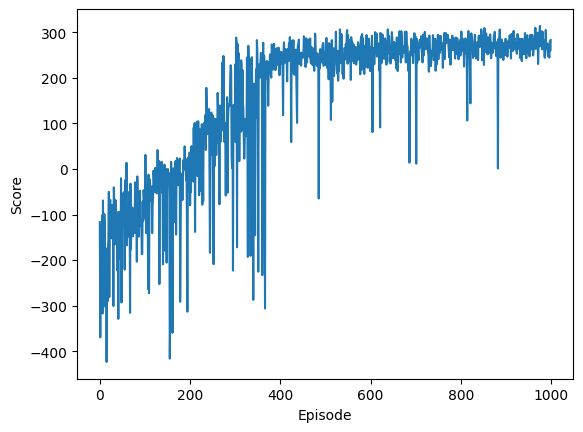

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

### Loss

Text(0, 0.5, 'Loss')

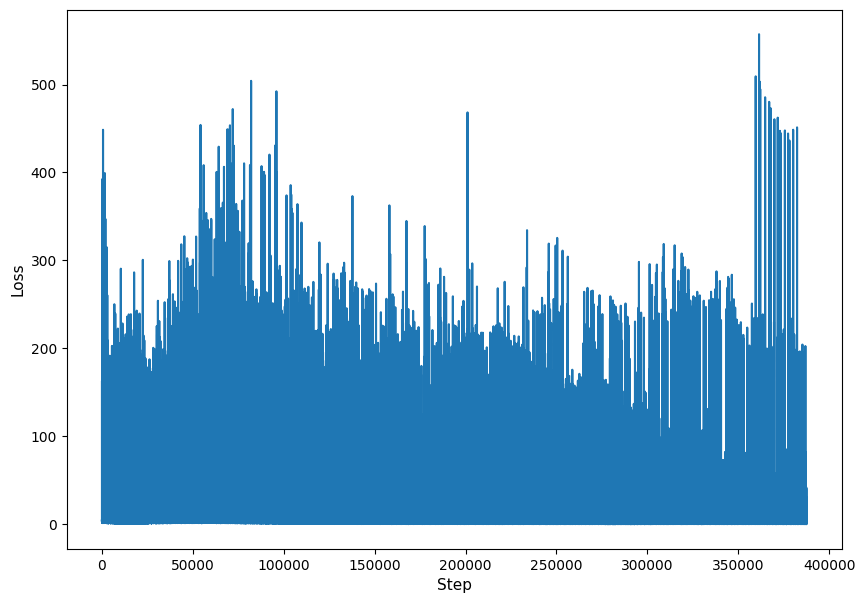

In [11]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Step", fontsize=11)
plt.ylabel("Loss", fontsize=11)

## Test Model

In [16]:
import gym
import numpy as np
import torch

env = gym.make("LunarLander-v2")

L1 = 8
L2 = 64
L3 = 64
L4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2),
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3),
    torch.nn.ReLU(),
    torch.nn.Linear(L3, L4)
)
PATH = "model_state_dict_500.pt"
model.load_state_dict(torch.load(PATH))
model.eval()

def test_model(times):
    for i in range(times):
        cur_state = env.reset()
        step_count = 0
        score = 0
        done = False
        
        while not done:
            step_count += 1
            cur_state = torch.tensor(cur_state)
            pred_Q = model(cur_state).data.numpy()
            action = np.argmax(pred_Q)

            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward
            cur_state = next_state
            
            if done:
                print("Game {} end at step {}, get score {:.2f}".format(i+1, step_count, score))
                break
            
    env.close()

test_model(20)

Game 1 end at step 224, get score 253.90
Game 2 end at step 1000, get score 118.88
Game 3 end at step 220, get score 281.67
Game 4 end at step 241, get score 289.95
Game 5 end at step 183, get score 266.21
Game 6 end at step 237, get score 265.63
Game 7 end at step 262, get score 251.83
Game 8 end at step 165, get score 280.99
Game 9 end at step 202, get score 262.36
Game 10 end at step 1000, get score 107.01
Game 11 end at step 178, get score 258.09
Game 12 end at step 171, get score 264.28
Game 13 end at step 210, get score 288.86
Game 14 end at step 145, get score 276.86
Game 15 end at step 144, get score 1.33
Game 16 end at step 224, get score 264.17
Game 17 end at step 231, get score 270.73
Game 18 end at step 321, get score 257.45
Game 19 end at step 225, get score 255.99
Game 20 end at step 403, get score 254.70
